## Data Science Case Study: Data-Driven Marketing
The Bank Marketing Data Set take from the [from the UCI repository](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing). The desciption and data set details below are directly from the data set documentation.

**Description**: The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).

There are four datasets; we will use the ``bank-additional-full.csv`` with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014].

### Input variables:

#### bank client data:
1. ``age`` (numeric)
2. ``job``: type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
3. ``marital``: marital status (categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed)
4. ``education`` (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
5. ``default``: has credit in default? (categorical: 'no','yes','unknown')
6. ``housing``: has housing loan? (categorical: 'no','yes','unknown')
7. ``loan``: has personal loan? (categorical: 'no','yes','unknown')

#### related with the last contact of the current campaign:
8. ``contact``: contact communication type (categorical: 'cellular','telephone')
9. ``month``: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. ``day_of_week``: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. ``duration``: last contact duration, in seconds (numeric). _Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model._

#### other attributes:
12. ``campaign``: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. ``pdays``: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. ``previous``: number of contacts performed before this campaign and for this client (numeric)
15. ``poutcome``: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### social and economic context attributes
16. ``emp.var.rate``: employment variation rate - quarterly indicator (numeric)
17. ``cons.price.idx``: consumer price index - monthly indicator (numeric)
18. ``cons.conf.idx``: consumer confidence index - monthly indicator (numeric)
19. ``euribor3m``: euribor 3 month rate - daily indicator (numeric). _The Euro Interbank Offered Rate (Euribor) is a daily reference rate, published by the European Money Markets Institute._
20. ``nr.employed``: number of employees - quarterly indicator (numeric)

### Output variable:
21. ``y`` - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
# General imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
# Load data set
data_file = './bank-additional-full.csv'
df = pd.read_csv(data_file, sep=';')

# Drop 'duration' column as it is essentially another output variable
df = df.drop('duration', axis=1)
df.head()

FileNotFoundError: [Errno 2] No such file or directory: './bank-additional-full.csv'

The code below splits into training and test sets and pre-processes them. The continuous features are scaled to between 0 and 1 using scikit-learn’s ``MinMaxEncoder`` and the categorical features are encoded with ``OrdinalEncoder``.

In [21]:
from sklearn.model_selection import train_test_split

# Split the dataframe into features and labels
y = df['y']
X = df.drop('y', axis=1)

# Split into train and test with stratified sampling to preserve class balances
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, stratify=y, test_size=0.25) 

In [22]:
# Preprocess the labels
from sklearn.preprocessing import LabelEncoder

preprocess_labels = LabelEncoder()
ytrn = preprocess_labels.fit_transform(ytrn).astype(float)
ytst = preprocess_labels.transform(ytst)

In [23]:
# Preprocess the features
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

cat_features = ['default', 'housing', 'loan', 'contact', 'poutcome', 
                'job', 'marital', 'education', 'month', 'day_of_week']
cntnous_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                    'cons.price.idx', 'cons.conf.idx', 'nr.employed', 'euribor3m']

preprocess_categorical = Pipeline(steps=[('encoder', OrdinalEncoder())])
preprocess_numerical = Pipeline(steps=[('scaler', MinMaxScaler())])
data_transformer = ColumnTransformer(transformers=[('categorical', preprocess_categorical, cat_features),
                                                   ('numerical', preprocess_numerical, cntnous_features)])
all_features = cat_features + cntnous_features

Xtrn = pd.DataFrame(data_transformer.fit_transform(Xtrn), columns=all_features)
Xtst = pd.DataFrame(data_transformer.transform(Xtst), columns=all_features)

In [24]:
Xtst.head()

,default,housing,loan,contact,poutcome,job,marital,education,month,day_of_week,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,euribor3m
0,0.0,0.0,0.0,0.0,1.0,9.0,1.0,5.0,1.0,1.0,0.222222,0.023810,1.0,0.000000,1.000000,0.484412,0.615063,1.0,0.981410
1,1.0,2.0,0.0,0.0,1.0,9.0,1.0,5.0,1.0,1.0,0.222222,0.095238,1.0,0.000000,1.000000,0.484412,0.615063,1.0,0.981410
2,0.0,0.0,0.0,0.0,0.0,9.0,2.0,6.0,9.0,0.0,0.209877,0.071429,1.0,0.166667,0.479167,0.778644,0.556485,0.0,0.055543
3,0.0,0.0,2.0,1.0,1.0,0.0,1.0,3.0,4.0,0.0,0.222222,0.071429,1.0,0.000000,1.000000,0.882307,0.376569,1.0,0.980503
4,0.0,2.0,0.0,1.0,1.0,2.0,1.0,0.0,4.0,3.0,0.320988,0.023810,1.0,0.000000,1.000000,0.882307,0.376569,1.0,0.958966


### Modeling with XGBoost
The code below shows how we can train an XGBoost ensemble over this data set. We use randomized grid search combined with 5-fold cross validation and early stopping to select among various hyperparameters such as learning rate and regularization parameters.

In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb_params = {'learning_rate': [0.001, 0.01, 0.1],  # Learning rate  
              'n_estimators': [100],                # Maximum number of trees
              'max_depth': [3, 5, 7, 9],            # Maximum tree depth     
             }


# xgb = XGBClassifier(objective='binary:logistic', early_stopping_rounds=15, eval_metric='aucpr') 
xgb = XGBClassifier() 
xgb_search = RandomizedSearchCV(xgb, xgb_params, cv=5, n_iter=10, verbose=0, n_jobs=-1)
xgb_search.fit(X=Xtrn, y=ytrn.ravel(), eval_set=[(Xtst, ytst)], verbose=0)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [100]})

In [26]:
xgb_search.best_score_

0.9011362172368098

In [27]:
xgb_search.best_params_

{'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

<BarContainer object of 19 artists>

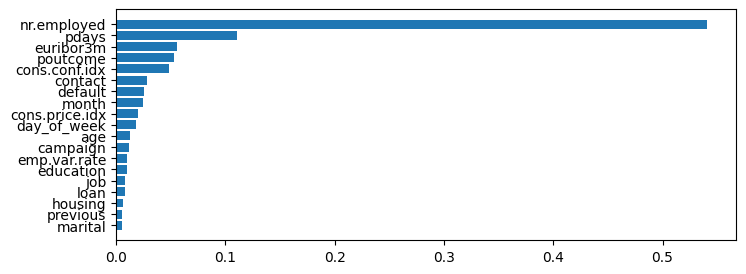

In [28]:
# Each XGBoost ensemble has its own feature importances
scores = xgb_search.best_estimator_.feature_importances_
features = Xtrn.columns.to_numpy()
srtd = np.argsort(scores)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
ax.barh(y=features[srtd], width=scores[srtd])

## Methods for Global Explainability
Methods for machine-learning model explainability can be categorized into two types:
- global methods attempt to generally explain a model’s decision-making process, and what factors are broadly relevant, while
- local methods attempt to specifically explain a model’s decision-making process with respect to individual examples and predictions.

Global explainability speaks to a model’s sensible behavior over a large number of examples when deployed or used in practice, while local explainability speaks to a model’s individual predictions on single examples that allow the user to make decisions on what to do next.

### Permutation Feature Importance
Permutation feature importance calculates the feature importance scores by randomly permuting or shuffling the feature column and computing the change in some evaluation metric. The evaluation metric is ideally used on a held-out test set. This is a model agnostic method and can be applied to any machine-learning method.

The code snipped snippet below computes permutation feature importances for the XGBClassifier trained in the previous section using ``balanced_accuracy`` and ``recall``.


In [29]:
xgb = xgb_search.best_estimator_
from sklearn.inspection import permutation_importance
metrics = ['accuracy', 'recall']
pfi_scores = {}
for metric in metrics:
    print('Computing permutation importance with {0}...'.format(metric))
    pfi_scores[metric] = permutation_importance(xgb, Xtst, ytst, scoring=metric, n_repeats=30, random_state=7)

Computing permutation importance with accuracy...
Computing permutation importance with recall...


In [30]:
pfi_scores.keys()

dict_keys(['accuracy', 'recall'])

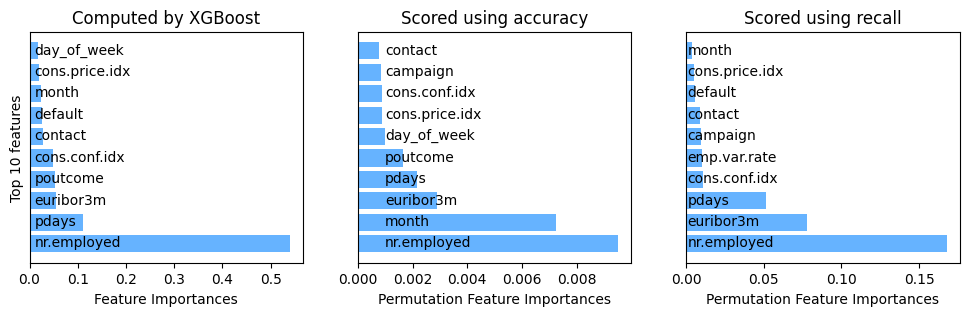

In [31]:
features = Xtst.columns.values
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

scores = xgb.feature_importances_
features = Xtst.columns.to_numpy()
srtd = np.argsort(-scores)

top = 10
ax[0].barh(y=np.arange(0, top), width=scores[srtd[:top]], color='#0081ff', alpha=0.6)
for i in range(top):
    ax[0].text(0.01, i-0.15, features[srtd[i]])
ax[0].set_yticks([])
ax[0].set_ylabel('Top {0} features'.format(top));
ax[0].set_xlabel('Feature Importances')
ax[0].set_title('Computed by XGBoost')

for k, metric in enumerate(metrics):
    scores = pfi_scores[metric]['importances_mean']
    srtd = np.argsort(-scores)
    
    ax[k+1].barh(y=np.arange(0, top), width=scores[srtd[:top]], color='#0081ff', alpha=0.6)
    for i in range(top):
        ax[k+1].text(0.001, i-0.15, features[srtd[i]])
    ax[k+1].set_yticks([])
    # ax[k+1].set_ylabel('Top {0} features scored with {1}'.format(top, metric));
    ax[k+1].set_xlabel('Permutation Feature Importances')
    ax[k+1].set_title('Scored using {0}'.format(metric))

### 9.3.2. Partial Dependence Plots
Partial dependence plots are another useful black-box approach, which help us identify the nature of the relationship between a feature and the target. 

Unlike permutation feature importance, which uses randomization to elicit the importance of a feature, the partial dependence relationship is identified using marginalization, or summing out. 

Partial dependence plots are intuitive to create and use, though can be somewhat time-consuming as new modified versions of the data set have to be created and evaluated for each point in the dependence plot. Here are some important technical details to keep in mind:
- Partial dependence tries to relate a model’s output to input features, that is, model behavior in terms of what it has learned. For this reason, it is best to create and visualize a partial dependence plot with the training set.
- Remember that a partial dependence function is created by averaging across n examples.

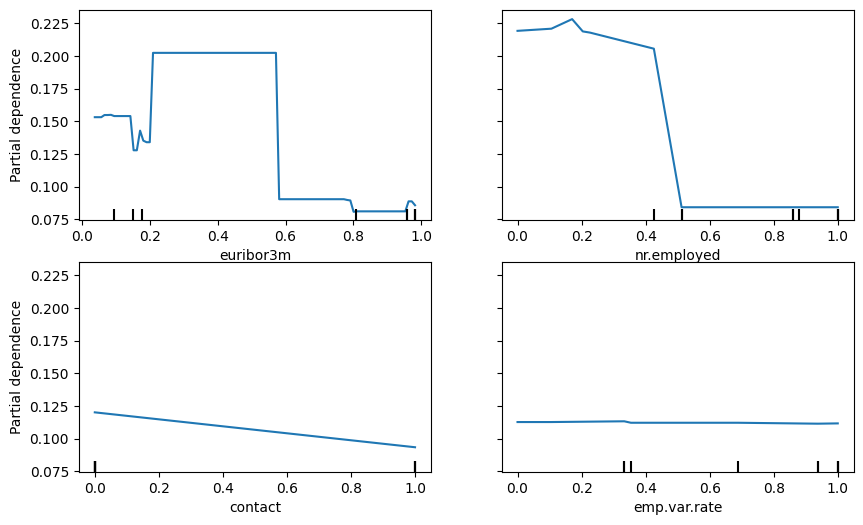

In [32]:
from sklearn.inspection import PartialDependenceDisplay as pdp
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
pdp.from_estimator(xgb, Xtrn, 
                   features=['euribor3m', 'nr.employed', 'contact', 'emp.var.rate'], 
                   feature_names=list(Xtrn.columns),
                   kind='average', response_method='predict_proba', 
                   ax=ax)

### Global Surrogate Models
The idea of a surrogate model is extremely simple: we train a second model that mimics the behavior of the black-box model. However, the surrogate model itself is a glass box and inherently explainable. Once trained, we can use the surrogate glass-box model to explain the predictions of the black-box model. 

To train a useful surrogate model, we will need to find the sweet spot in the fidelity-interpretability tradeoff. This sweet spot will be a surrogate model that approximates the black-box’s predictions pretty well but is also not so complex that it defies any interpretation (possibly by inspection).

In [47]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, r2_score

yb_trn_pred = xgb.predict(Xtrn)  # Training set predictions of the black-box (XGBoost) model
yb_tst_pred = xgb.predict(Xtst)  # Test set predictions of the black-box (XGBoost) model

acc={}

leaf_limits = [8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
for max_leaf_nodes in leaf_limits:
    print('Surrogate max-leaf-nodes = {0}'.format(max_leaf_nodes))
    surrogate = DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes, criterion='gini', 
                                       min_samples_leaf=20, class_weight={0: 1, 1: 10})
    surrogate.fit(Xtrn, yb_trn_pred)
    ys_trn_pred = surrogate.predict(Xtrn)
    ys_tst_pred = surrogate.predict(Xtst)
       
    acc[max_leaf_nodes] = {'trn': {'black-box': accuracy_score(ytrn, yb_trn_pred),
                                   'surrogate': accuracy_score(ytrn, ys_trn_pred),},
                           'tst': {'black-box': accuracy_score(ytst, yb_tst_pred),
                                   'surrogate': accuracy_score(ytst, ys_tst_pred),}}

Surrogate max-leaf-nodes = 8
Surrogate max-leaf-nodes = 10
Surrogate max-leaf-nodes = 12
Surrogate max-leaf-nodes = 14
Surrogate max-leaf-nodes = 16
Surrogate max-leaf-nodes = 18
Surrogate max-leaf-nodes = 20
Surrogate max-leaf-nodes = 22
Surrogate max-leaf-nodes = 24
Surrogate max-leaf-nodes = 26


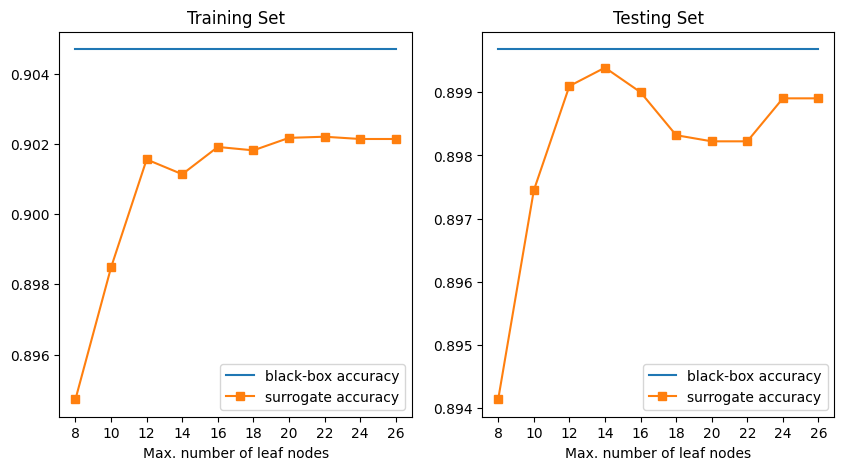

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

fig_labels = ['Training Set', 'Testing Set']
markers = [None, 's', 'o']
for i, dset in enumerate(['trn', 'tst']):
    for j, curve in enumerate(['black-box', 'surrogate']):
        z = [acc[mleaf][dset][curve] for mleaf in leaf_limits]
        ax[i].plot(leaf_limits, z, marker=markers[j])
    ax[i].legend(['black-box accuracy', 'surrogate accuracy'])
    ax[i].set_title(fig_labels[i])
    ax[i].set_xlabel('Max. number of leaf nodes')
    #ax[i].set_ylabel('accuracy / r2 score')
    ax[i].set_xticks(leaf_limits)

A decision-tree surrogate with 14 leaf nodes seems to achieve the ideal tradeoff between fidelity and complexity for explainability. The code below trains a surrogate decision-tree model with these specifications.

In [34]:
surrogate = DecisionTreeClassifier(max_leaf_nodes=14, criterion='gini', 
                                   min_samples_leaf=20, class_weight={0: 1, 1: 10})
surrogate.fit(Xtrn, yb_trn_pred)

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, max_leaf_nodes=14,
                       min_samples_leaf=20)

In [ ]:
import graphviz, re
from sklearn import tree

features = Xtst.columns.to_numpy()
dot = tree.export_graphviz(surrogate, feature_names=features, # leaves_parallel=True,
                           class_names=['N', 'Y'],
                           filled=True, impurity=False)
dot = re.sub('(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])', '', dot)
dot = re.sub('(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n', '', dot)
graphviz.Source(dot, format="png")

## Methods for Local Explainability
In this section, we will explore methods for local explainability, which aim to explain a model’s individual predictions. The explanations allow users  to trust the predictions and take actions based on them. This is tied to the user’s ability to understand why a model made a particular decision.

### Local Interpretable Model-Agnostic Explanations
The overall goal of LIME is to identify an interpretable model over the interpretable representation that is locally faithful to the classifier. LIME was originally proposed by Ribeiro, Singh & Guestrin [[1]](https://arxiv.org/abs/1602.04938).

In [44]:
cat_features = ['default', 'housing', 'loan', 'contact', 'poutcome', 
                'job', 'marital', 'education', 'month', 'day_of_week']
cat_idx = np.array([cat_features.index(f) for f in cat_features])

from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(Xtrn.values,
                                              feature_names=list(Xtrn.columns), 
                                              class_names=['Sub?=NO', 'Sub?=YES'], 
                                              categorical_features=cat_idx,
                                              kernel_width=75.0,
                                              categorical_names=cat_features,
                                              discretize_continuous=False)

In [45]:
exp = explainer.explain_instance(Xtst.iloc[8024], xgb.predict_proba)
exp.show_in_notebook(show_table=False, show_all=False)

### 9.4.2. Shapley Values and TreeSHAP
SHAP is a model-agnostic black-box explainer, which is used to explain individual predictions (hence, local interpretability) through feature importance. SHAP is a feature attribution technique that computes feature importance based on each feature’s contribution to the overall prediction. SHAP is built upon the concept of Shapley values, which comes from the field of co-operative game theory.

SHAP is available as a package available through Python’s two most popular package managers: pip and anaconda. The package’s [GitHub page](https://github.com/slundberg/shap)   also contains additional documentation and a number of examples illustrating how to use it for classification, regression and applications in text and image analytics.

We use a version of SHAP called TreeSHAP that is specifically designed to be used for tree-based models, including individual decision trees and ensembles. TreeSHAP is a special variant of SHAP that exploits the unique structure of decision treesShapley values efficiently. 

TreeSHAP supports many of the ensemble methods discussed in this lecture, including XGBoost. The listing below shows how to compute and interpret the Shapley values for test example of the bank marketing data set using an XGBoost model.

In [38]:
import shap
explainer = shap.TreeExplainer(xgb, feature_names=list(Xtrn.columns))
shap_values = explainer(Xtst.iloc[8024].values.reshape(1, -1))

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


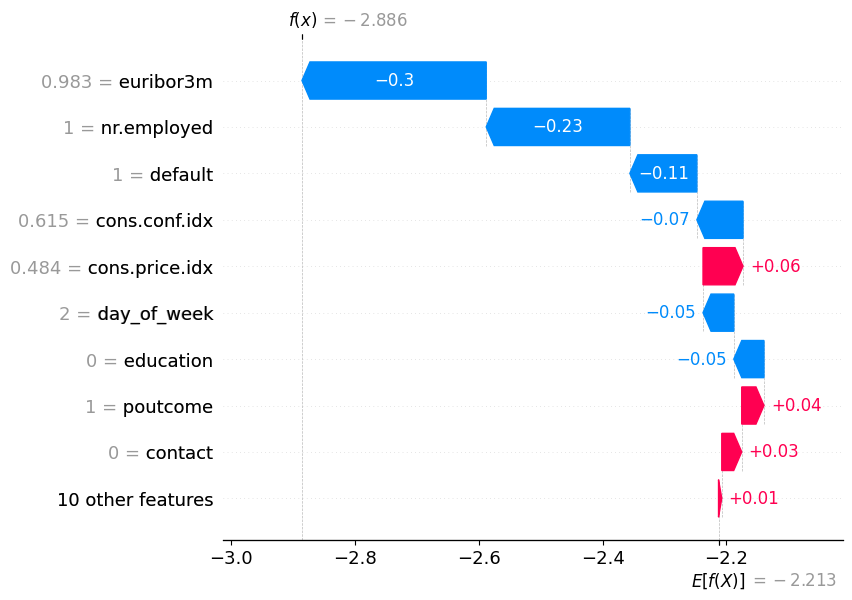

In [39]:
shap.plots.waterfall(shap_values[0])